# Experiment on AAI Model Architectures
- Created: 10 Mar 2020
- Data: param_draft1

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from os.path import join
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks
from time import time
from datetime import datetime
import shutil 
import argparse
from functools import partial
import pickle
from IPython.display import Audio

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Reshape, GRU, InputLayer, AlphaDropout, Activation, BatchNormalization, Dropout, Flatten, Dense, Bidirectional, LSTM, Conv1D, SpatialDropout1D, Concatenate, Multiply, Add

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

In [2]:
np_load_old = partial(np.load)
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [3]:
tf.random.set_seed(42)

## Metric Function

In [4]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def R2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred), axis = 0) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true, axis = 0)), axis = 0) 
    return K.mean(1 - (SS_res/SS_tot), axis=0)

## Utility Functions

In [5]:
#Function for preprocessing data
def delete_params(params):
    '''
    This function remove JX, WC, TRX, TRY, and MS1,2,3 paramter
    '''
    DEL_PARAMS_LIST = [2,8,15,16,21,22,23]
    return np.delete(params,DEL_PARAMS_LIST , axis=1)

In [6]:
def compute_rmse(actual,pred, axis=1):
    # Compute RMSE by row (axis=1) result in rmse of each data
    # Compute RMSE by column (axis=0) result in rmse of each label
    return np.sqrt((np.square(actual - pred)).mean(axis=axis))

In [7]:
def evaluate_model(y_pred, label):
    y_pred = enc.inverse_transform(y_pred)
    label = enc.inverse_transform(label)
#     print('Confusion Matrix')
#     print(confusion_matrix(label, y_pred))
    print('Classification Report')
    print(classification_report(label, y_pred))

In [8]:
def compute_se(actual,pred):
    return np.sqrt((np.square(actual - pred)))

## Load Data 

In [9]:
def prep_data():

    # load data from preprocess pipeline
    dataset = np.load(join('../../data/d_dataset_p1/prep_data_13_2','training_subsets.npz'))
    X_train =dataset['X_train']
    y_train= dataset['y_train']
    z_train= dataset['z_train']
    X_val = dataset['X_val']
    y_val = dataset['y_val']
    z_val = dataset['z_val']
    X_test = dataset['X_test']
    y_test = dataset['y_test']
    z_test = dataset['z_test']
    a_test = dataset['audio_test']
    a_val = dataset['audio_val']
    
    y_train = delete_params(y_train)
    y_val = delete_params(y_val)
    y_test = delete_params(y_test)

    print('Train features and labels %s %s'%(str(X_train.shape),str(y_train.shape)))
    print('Validating features and labels %s %s'%(str(X_val.shape),str(y_val.shape)))
    print('Test features and labels %s %s'%(str(X_test.shape),str(y_test.shape)))

    return X_train, X_val, X_test, y_train, y_val, y_test, z_train, z_val, z_test, a_test, a_val

In [10]:
X_train, X_val, X_test, y_train, y_val, y_test, z_train, z_val, z_test, a_test, a_val = prep_data()

Train features and labels (98746, 24, 39) (98746, 17)
Validating features and labels (12094, 24, 39) (12094, 17)
Test features and labels (12092, 24, 39) (12092, 17)


In [11]:
print(set(z_test))

{'7', 'Q', '2', '@', 'U', 'a', 'u', 'A', '9', 'E:', 'O', 'M', 'o', 'E', 'V', 'e', 'i', '&', 'y'}


In [12]:
print('Train features and labels {} {} {}'.format(str(X_train.shape),str(y_train.shape),str(z_train.shape)))
print('Validating features and labels {} {} {}'.format(str(X_val.shape),str(y_val.shape),str(z_val.shape)))
print('Test features and labels {} {} {}'.format(str(X_test.shape),str(y_test.shape),str(z_test.shape)))

Train features and labels (98746, 24, 39) (98746, 17) (98746,)
Validating features and labels (12094, 24, 39) (12094, 17) (12094,)
Test features and labels (12092, 24, 39) (12092, 17) (12092,)


### One-hot label 

In [13]:
z_train_oe=z_train.reshape(-1,1)
z_val_oe=z_val.reshape(-1,1)
z_test_oe=z_test.reshape(-1,1)

enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(z_train_oe)

z_train_oe = enc.transform(z_train_oe).toarray()
z_test_oe = enc.transform(z_test_oe).toarray()
z_val_oe = enc.transform(z_val_oe).toarray()

## 1.) Train Baseline Model
- Model without embedding feature

### Defined Model without Embedded Feature

In [14]:
N_OUTPUTS = 17

pLSTM = partial(LSTM, kernel_initializer='he_uniform', return_sequences=True)
pConv1D = partial(Conv1D, padding = 'same', activation = 'linear', kernel_initializer = 'he_uniform')

def init_senet(feature_layer=1, cnn_unit=64, first_kernel=11, res_unit=128, res_kernel=7,
    bilstm = 1, bilstm_unit=256, 
    dropout_rate=0.3,
    reduction_ratio = 2,
    activation_fn='relu'):


    def cnn_block(input_x, cnn_unit, kernel_size):
        x = pConv1D(cnn_unit, kernel_size=kernel_size)(input_x)
        x = BatchNormalization()(x)
        x = Activation(activation_fn)(x)
        return x

    def se_block(input_x):
        x = layers.GlobalAveragePooling1D()(input_x)
        channel_shape = getattr(x, '_shape_val')[-1]
        x = Reshape((1, channel_shape))(x)
        x = Dense(channel_shape // reduction_ratio, activation=activation_fn, kernel_initializer='he_uniform')(x)
        x = Dense(channel_shape, activation='tanh', kernel_initializer='he_uniform')(x)
        return x

    def residual_block(input_x):
        x = cnn_block(input_x, res_unit,kernel_size=res_kernel)
        x = pConv1D(res_unit, kernel_size=3)(x)
        x = BatchNormalization()(x)
        return x

    def se_res_block(input_x):
        res_x = residual_block(input_x)
        se_x = se_block(res_x)
        x = layers.Multiply()([res_x, se_x])
        x = Activation(activation_fn)(x)
        # input_x = cnn_block(input_x, cnn_unit=cnn_unit, kernel_size=1)
        outputs = layers.Add()([x, input_x])
        return outputs

    def senet_nn(input_shape_1,input_shape_2):

        input_x = keras.Input(shape=(input_shape_1,input_shape_2))
        x = cnn_block(input_x, 128, first_kernel)
        # layers.Concatenate()([x, embeded])
        for i in range(feature_layer):
            x = se_res_block(x)
        x = SpatialDropout1D(rate=dropout_rate)(x)
        for i in range(feature_layer):
            x = se_res_block(x)
            x = SpatialDropout1D(rate=dropout_rate)(x)
        x = cnn_block(x, cnn_unit=cnn_unit, kernel_size=1)
        x = SpatialDropout1D(rate=dropout_rate)(x)
        for i in range(bilstm-1):
            x = Bidirectional(pLSTM(bilstm_unit))(x)
            x = SpatialDropout1D(rate=dropout_rate)(x)
        x = Bidirectional(pLSTM(bilstm_unit, return_sequences=False))(x)
        x = Dropout(rate=dropout_rate)(x)
        outputs = Dense(N_OUTPUTS, activation='linear', kernel_initializer='he_uniform')(x)
        model = keras.Model(inputs=input_x, outputs=outputs)
        return model

    return senet_nn

In [15]:
model = init_senet()(24, 39)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 39)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 24, 128)      55040       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 24, 128)      512         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 24, 128)      0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Compile Model 

In [17]:
model.compile(optimizer='adam',loss='mse',metrics=[rmse, R2])

### Train Model 

In [18]:
PATIENCE = 10
BATCH_SIZE = 128
EPOCHS = 50

early = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=PATIENCE, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callback_list = [early]

In [19]:
history = model.fit(X_train,y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val,y_val),
    callbacks=callback_list)

Train on 98746 samples, validate on 12094 samples
Epoch 1/50
98746/98746 [==============================] - 32s 319us/sample - loss: 0.1098 - rmse: 0.3097 - R2: 0.5216 - val_loss: 0.0527 - val_rmse: 0.2080 - val_R2: 0.7719
Epoch 2/50
98746/98746 [==============================] - 21s 216us/sample - loss: 0.0692 - rmse: 0.2413 - R2: 0.7022 - val_loss: 0.0504 - val_rmse: 0.2007 - val_R2: 0.7846
Epoch 3/50
98746/98746 [==============================] - 21s 216us/sample - loss: 0.0609 - rmse: 0.2236 - R2: 0.7384 - val_loss: 0.0446 - val_rmse: 0.1891 - val_R2: 0.8083
Epoch 4/50
98746/98746 [==============================] - 21s 217us/sample - loss: 0.0557 - rmse: 0.2130 - R2: 0.7606 - val_loss: 0.0416 - val_rmse: 0.1802 - val_R2: 0.8208
Epoch 5/50
98746/98746 [==============================] - 21s 216us/sample - loss: 0.0528 - rmse: 0.2069 - R2: 0.7729 - val_loss: 0.0422 - val_rmse: 0.1802 - val_R2: 0.8200
Epoch 6/50
98746/98746 [==============================] - 21s 216us/sample - loss: 0.

In [20]:
model.save('model_baseline.hdf5')

### Evaluation 

In [21]:
model.evaluate(X_test,y_test,verbose=0)

[0.03375698116232416, 0.1563362, 0.84711534]

In [22]:
y_pred = model.predict(X_test)

In [23]:
err = compute_rmse(y_test,y_pred, axis=0)

In [24]:
print(err)

[0.16342768 0.14086562 0.14849178 0.20117811 0.16922748 0.22422665
 0.25635736 0.10536106 0.13922235 0.24446311 0.13874895 0.17061567
 0.17291206 0.26759069 0.18129253 0.15462481 0.15255724]


## 2.) Trained Embedding Layer 

### Defined Embedding Model

In [25]:
PHONETIC_OUTPUT = len(set(z_train))
EMBEDDED_FEATURE = 100

pLSTM = partial(LSTM, kernel_initializer='he_uniform', return_sequences=True)

def embeded_model(input_shape_1,input_shape_2):
    inputs = keras.Input(shape=(input_shape_1,input_shape_2))
    x = pLSTM(EMBEDDED_FEATURE)(inputs)
    x = Flatten()(x)
    outputs = Dense(PHONETIC_OUTPUT, activation='softmax', kernel_initializer='he_uniform')(x)
    return keras.Model(inputs=inputs, outputs=outputs)

In [26]:
embedded = embeded_model(24, 39)
embedded.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 24, 39)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 100)           56000     
_________________________________________________________________
flatten (Flatten)            (None, 2400)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 19)                45619     
Total params: 101,619
Trainable params: 101,619
Non-trainable params: 0
_________________________________________________________________


### Compile Model 

In [27]:
embedded.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

### Train Model 

In [28]:
PATIENCE = 10
BATCH_SIZE = 128
EPOCHS = 50

early = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=PATIENCE, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callback_list = [early]

In [29]:
history = embedded.fit(X_train,z_train_oe,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val,z_val_oe),
    callbacks=callback_list)

Train on 98746 samples, validate on 12094 samples
Epoch 1/50
98746/98746 [==============================] - 7s 67us/sample - loss: 2.3007 - accuracy: 0.7497 - val_loss: 2.1814 - val_accuracy: 0.8575
Epoch 2/50
98746/98746 [==============================] - 4s 41us/sample - loss: 2.2010 - accuracy: 0.8369 - val_loss: 2.1568 - val_accuracy: 0.8796
Epoch 3/50
98746/98746 [==============================] - 4s 41us/sample - loss: 2.1741 - accuracy: 0.8621 - val_loss: 2.1505 - val_accuracy: 0.8838
Epoch 4/50
98746/98746 [==============================] - 4s 42us/sample - loss: 2.1578 - accuracy: 0.8781 - val_loss: 2.1473 - val_accuracy: 0.8862
Epoch 5/50
98746/98746 [==============================] - 4s 41us/sample - loss: 2.1469 - accuracy: 0.8882 - val_loss: 2.1419 - val_accuracy: 0.8902
Epoch 6/50
98746/98746 [==============================] - 4s 41us/sample - loss: 2.1389 - accuracy: 0.8956 - val_loss: 2.1470 - val_accuracy: 0.8850
Epoch 7/50
98746/98746 [==============================] 

In [30]:
embedded.save('embedded.hdf5')

### Evaluated Model 

In [31]:
z_pred = embedded.predict(X_test)
evaluate_model(z_pred, z_test_oe)

Classification Report
              precision    recall  f1-score   support

           &       0.94      0.90      0.92       655
           2       0.94      0.96      0.95       636
           7       0.90      0.66      0.76       552
           9       0.92      0.95      0.93       625
           @       0.98      0.91      0.95       647
           A       0.86      0.93      0.89       619
           E       0.88      0.91      0.90       652
          E:       0.93      0.94      0.94       629
           M       0.87      0.94      0.90       650
           O       0.80      0.86      0.83       674
           Q       0.93      0.87      0.90       670
           U       0.89      0.81      0.85       641
           V       0.68      0.83      0.75       644
           a       0.92      0.90      0.91       644
           e       0.96      0.95      0.96       661
           i       0.98      0.94      0.96       650
           o       0.95      0.88      0.91       571
     

## 3.) Model with Embedding Feature 

### Embedded input model

In [32]:
embedded = tf.keras.models.load_model('embedded.hdf5')

embedded_layers = tf.keras.Sequential()
for layer in embedded.layers[:-2]:
    layer.trainable = False
    embedded_layers.add(layer)
embedded_layers.summary()

N_OUTPUTS = 17

pLSTM = partial(LSTM, kernel_initializer='he_uniform', return_sequences=True)
pConv1D = partial(Conv1D, padding = 'same', activation = 'linear', kernel_initializer = 'he_uniform')

def init_senet_w_emb(feature_layer=1, cnn_unit=64, first_kernel=11, res_unit=128, res_kernel=7,
    bilstm = 1, bilstm_unit=256, 
    dropout_rate=0.3,
    reduction_ratio = 2,
    activation_fn='relu'):


    def cnn_block(input_x, cnn_unit, kernel_size):
        x = pConv1D(cnn_unit, kernel_size=kernel_size)(input_x)
        x = BatchNormalization()(x)
        x = Activation(activation_fn)(x)
        return x

    def se_block(input_x):
        x = layers.GlobalAveragePooling1D()(input_x)
        channel_shape = getattr(x, '_shape_val')[-1]
        x = Reshape((1, channel_shape))(x)
        x = Dense(channel_shape // reduction_ratio, activation=activation_fn, kernel_initializer='he_uniform')(x)
        x = Dense(channel_shape, activation='tanh', kernel_initializer='he_uniform')(x)
        return x

    def residual_block(input_x):
        x = cnn_block(input_x, res_unit,kernel_size=res_kernel)
        x = pConv1D(res_unit, kernel_size=3)(x)
        x = BatchNormalization()(x)
        return x

    def se_res_block(input_x):
        res_x = residual_block(input_x)
        se_x = se_block(res_x)
        x = layers.Multiply()([res_x, se_x])
        x = Activation(activation_fn)(x)
#         input_x = cnn_block(input_x, cnn_unit=res_unit, kernel_size=1)
        x = layers.Add()([x, input_x])
        return x

    def senet_nn(input_shape_1,input_shape_2):

        input_x = keras.Input(shape=(input_shape_1,input_shape_2))
        embedded = embedded_layers(input_x)
        x = layers.Concatenate()([input_x, embedded])
        x = cnn_block(input_x, 128, first_kernel)

        for i in range(feature_layer):
            x = se_res_block(x)
        x = SpatialDropout1D(rate=dropout_rate)(x)
        for i in range(feature_layer):
            x = se_res_block(x)
            x = SpatialDropout1D(rate=dropout_rate)(x)
        x = cnn_block(x, cnn_unit=cnn_unit, kernel_size=1)
        x = SpatialDropout1D(rate=dropout_rate)(x)
        for i in range(bilstm-1):
            x = Bidirectional(pLSTM(bilstm_unit))(x)
            x = SpatialDropout1D(rate=dropout_rate)(x)
        x = Bidirectional(pLSTM(bilstm_unit, return_sequences=False))(x)
        x = Dropout(rate=dropout_rate)(x)
        outputs = Dense(N_OUTPUTS, activation='linear', kernel_initializer='he_uniform')(x)
        model = keras.Model(inputs=input_x, outputs=outputs)
        return model

    return senet_nn

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 24, 100)           56000     
Total params: 56,000
Trainable params: 0
Non-trainable params: 56,000
_________________________________________________________________


In [33]:
emb_model = init_senet_w_emb()(24, 39)
emb_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 24, 39)]     0                                            
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 24, 128)      55040       input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 24, 128)      512         conv1d_6[0][0]                   
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 24, 128)      0           batch_normalization_6[0][0]      
____________________________________________________________________________________________

### Compile Model 

In [34]:
emb_model.compile(optimizer='adam',loss='mse',metrics=[rmse, R2])

### Train Model 

In [35]:
PATIENCE = 10
BATCH_SIZE = 128
EPOCHS = 50

early = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=PATIENCE, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callback_list = [early]

In [36]:
history = emb_model.fit(X_train,y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=2,
    validation_data=(X_val,y_val),
    callbacks=callback_list)

Train on 98746 samples, validate on 12094 samples
Epoch 1/50
98746/98746 - 29s - loss: 0.1100 - rmse: 0.3099 - R2: 0.5200 - val_loss: 0.0515 - val_rmse: 0.2054 - val_R2: 0.7769
Epoch 2/50
98746/98746 - 21s - loss: 0.0688 - rmse: 0.2405 - R2: 0.7035 - val_loss: 0.0467 - val_rmse: 0.1944 - val_R2: 0.7995
Epoch 3/50
98746/98746 - 21s - loss: 0.0607 - rmse: 0.2232 - R2: 0.7392 - val_loss: 0.0457 - val_rmse: 0.1887 - val_R2: 0.8032
Epoch 4/50
98746/98746 - 21s - loss: 0.0562 - rmse: 0.2138 - R2: 0.7583 - val_loss: 0.0448 - val_rmse: 0.1846 - val_R2: 0.8063
Epoch 5/50
98746/98746 - 21s - loss: 0.0534 - rmse: 0.2080 - R2: 0.7704 - val_loss: 0.0410 - val_rmse: 0.1781 - val_R2: 0.8246
Epoch 6/50
98746/98746 - 21s - loss: 0.0510 - rmse: 0.2032 - R2: 0.7805 - val_loss: 0.0401 - val_rmse: 0.1758 - val_R2: 0.8289
Epoch 7/50
98746/98746 - 21s - loss: 0.0492 - rmse: 0.1992 - R2: 0.7883 - val_loss: 0.0405 - val_rmse: 0.1766 - val_R2: 0.8273
Epoch 8/50
98746/98746 - 21s - loss: 0.0478 - rmse: 0.1962 - 

In [37]:
emb_model.save('model_with_embedded.hdf5')

## 4.) Evaluation 

In [38]:
emb_model = tf.keras.models.load_model('model_with_embedded.hdf5', custom_objects={'rmse': rmse, 'R2':R2})

In [39]:
emb_model.evaluate(X_test,y_test,verbose=0)

[0.03374897229219958, 0.15754908, 0.84626794]

In [40]:
y_pred = emb_model.predict(X_test)

### Check error by each data 

In [41]:
errs = compute_rmse(y_test,y_pred, axis=1)

In [42]:
print(err)

[0.16342768 0.14086562 0.14849178 0.20117811 0.16922748 0.22422665
 0.25635736 0.10536106 0.13922235 0.24446311 0.13874895 0.17061567
 0.17291206 0.26759069 0.18129253 0.15462481 0.15255724]


### Error rank by highest 

In [43]:
err_df = pd.DataFrame({'phonetic':z_test, 'err':errs})

In [44]:
err_df.head()

,phonetic,err
0,2,0.140931
1,2,0.110135
2,O,0.097975
3,i,0.095773
4,Q,0.145450


In [45]:
err_df.sort_values('err')

,phonetic,err
192,A,0.039040
4633,Q,0.042389
10310,A,0.043910
3107,A,0.045392
6532,a,0.045756
...,...,...
1190,9,0.722524
7173,&,0.731410
575,7,0.732977
2917,&,0.733672


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000152CF5EFB70>]],
      dtype=object)

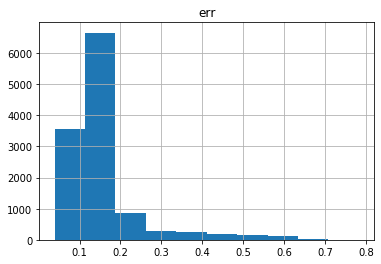

In [46]:
err_df.hist('err')

In [47]:
err_df_high = err_df[err_df['err'] > 0.15]

In [48]:
err_df_high.head()

,phonetic,err
5,&,0.297255
6,e,0.155565
10,e,0.170402
13,&,0.151975
15,&,0.351055


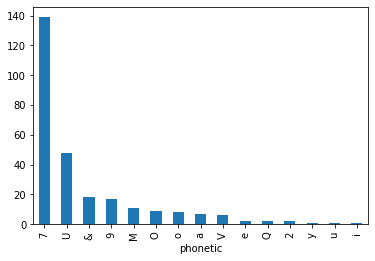

In [49]:
err_df[err_df['err'] > 0.5].groupby('phonetic')['phonetic'].count().sort_values(ascending=False).plot.bar()

In [50]:
err_df_high.groupby('phonetic')['phonetic'].count()

phonetic
&     209
2     150
7     371
9     251
@     196
A     126
E     189
E:    186
M     196
O     227
Q     267
U     235
V     298
a     198
e     252
i     279
o     186
u     197
y     196
Name: phonetic, dtype: int64

## Evaluate each param of each row

In [51]:
se = compute_se(y_test,y_pred)
errs = compute_rmse(y_test,y_pred, axis=1)

In [52]:
df_se = pd.DataFrame(se, columns=["HX","HY","JA","LP","LD","VS","VO","TCX","TCY","TTX","TTY","TBX","TBY","TS1","TS2","TS3","TS4"])

In [53]:
df_se['phonetic'] = z_test
df_se['mean_err'] = errs
df_se['audio'] = a_test

In [54]:
df_se.head()

,HX,HY,JA,LP,LD,VS,VO,TCX,TCY,TTX,TTY,TBX,TBY,TS1,TS2,TS3,TS4,phonetic,mean_err,audio
0,0.013928,0.034768,0.057325,0.061897,0.008357,0.327412,0.306621,0.075086,0.125826,0.061458,0.021835,0.070493,0.207759,0.181334,0.072151,0.126017,0.004179,2,0.140931,"[0.03047676, 0.02607328, 0.02177687, 0.0147435..."
1,0.223792,0.053807,0.049493,0.078881,0.108626,0.269052,0.055595,0.094974,0.136904,0.008289,0.070980,0.077523,0.016608,0.100532,0.067455,0.007944,0.058322,2,0.110135,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0.039658,0.041555,0.150124,0.054038,0.123018,0.113912,0.215230,0.031136,0.035159,0.039267,0.114198,0.062079,0.057162,0.155818,0.053354,0.049998,0.080367,O,0.097975,"[0.016970541, 0.026040426, 0.33393437, 0.07212..."
3,0.088391,0.018826,0.017995,0.279035,0.158209,0.025643,0.076012,0.002740,0.013970,0.099198,0.059670,0.124889,0.001723,0.041424,0.080630,0.010610,0.024136,i,0.095773,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0.163511,0.085784,0.005386,0.010458,0.211310,0.054206,0.011667,0.022072,0.011920,0.023298,0.459579,0.101888,0.199704,0.094994,0.001859,0.016301,0.075792,Q,0.145450,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


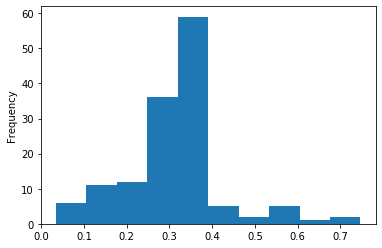

In [55]:
df_se[(df_se['phonetic'] == '7') & (df_se['mean_err'] > 0.5)]['TS4'].plot.hist()

## EDA audio of testing data 

In [56]:
df_se_sort = df_se.sort_values('mean_err',ascending=False)
df_se_sort.reset_index(drop=True, inplace=True)

In [57]:
df_se_sort[df_se_sort['phonetic'] == '&'].head(n=5)

,HX,HY,JA,LP,LD,VS,VO,TCX,TCY,TTX,TTY,TBX,TBY,TS1,TS2,TS3,TS4,phonetic,mean_err,audio
0,0.710753,0.587594,0.369504,0.398695,0.996962,1.269399,1.233598,0.009169,0.690211,0.210949,0.143965,0.920339,0.704394,1.327637,0.541208,0.932953,0.559281,&,0.782027,"[0.052336212, 0.049636144, 0.054873876, 0.0609..."
1,0.712101,0.305774,0.352733,0.166203,0.803425,1.015350,1.234057,0.014962,0.723865,0.196452,0.166923,0.874803,0.414167,1.292014,0.863222,1.015473,0.474971,&,0.733672,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,0.688856,0.072608,0.368708,0.405895,1.044679,0.812638,1.287480,0.015699,0.640360,0.431142,0.135031,0.771422,0.571857,1.383786,0.823062,0.637546,0.607612,&,0.731410,"[0.0012514566, -0.00038389416, -0.001600003, -..."
6,0.685121,0.173930,0.340893,0.263873,0.945189,1.246128,1.261761,0.034838,0.534414,0.322117,0.280611,0.682158,0.407848,1.073195,0.853633,0.618489,0.485611,&,0.699727,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,0.686499,0.320386,0.279341,0.169526,0.744595,1.223197,0.968626,0.043615,0.538692,0.319012,0.099576,0.760214,0.480990,1.173229,0.867032,0.844318,0.408873,&,0.681300,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [58]:
Audio(df_se_sort['audio'][0], rate=16000)

In [59]:
df_se_sort[df_se_sort['phonetic'] == '&'].tail(n=5)

,HX,HY,JA,LP,LD,VS,VO,TCX,TCY,TTX,TTY,TBX,TBY,TS1,TS2,TS3,TS4,phonetic,mean_err,audio
12018,0.026014,0.077944,0.070249,0.134137,0.001800,0.066682,0.002853,0.027363,0.030012,0.025399,0.033139,0.005343,0.057140,0.110335,0.024621,0.081993,0.011631,&,0.059637,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12047,0.110425,0.028072,0.114689,0.089873,0.034710,0.055709,0.006648,0.017717,0.009406,0.040349,0.057743,0.000390,0.078181,0.052768,0.027665,0.002817,0.015793,&,0.056281,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12053,0.047034,0.055303,0.102388,0.007499,0.030418,0.052109,0.023194,0.041007,0.017608,0.043595,0.023204,0.073937,0.051734,0.112092,0.067809,0.047360,0.021625,&,0.055538,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12074,0.109885,0.000068,0.065281,0.008221,0.076719,0.091554,0.010259,0.024032,0.006307,0.061694,0.026769,0.007651,0.031000,0.067899,0.045695,0.033716,0.002067,&,0.051321,"[-0.024614912, -0.027256025, -0.0038479252, 0...."
12083,0.001166,0.044024,0.064616,0.004200,0.064010,0.087467,0.002739,0.049409,0.039001,0.040528,0.003892,0.049076,0.006176,0.083561,0.061314,0.042373,0.031856,&,0.048207,"[-0.009346896, -0.014247213, -0.01946641, -0.0..."


In [60]:
Audio(df_se_sort['audio'][12073], rate=16000)